# Interactive Introduction to ML and AI with a RAG-System

Based on a PDF containing 

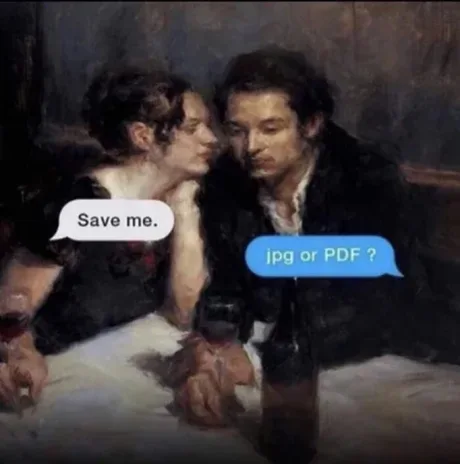

In [13]:
import openai
import os
from dotenv import load_dotenv
from langchain.document_loaders import PyPDFLoader
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma

## Load PDF data
Loads the data and splits it into chunks.
Each chunk contains 1000 characters max with a max overlap of 1000 characters.

In [14]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
loader = PyPDFLoader("data/StarterSet_Charactersv2.pdf")
chunks = loader.load_and_split(text_splitter)

### Check the chunks
get chunk content with: chunks[index].page_content

In [15]:
print(chunks[0])
print("The chunk contains " +  + " characters")

page_content='raceclass & level Player Name\ncharacter NameBackgrouNd\nexPerieNce PoiNts aligNmeNt\nSKILLSHit Point Maximum\nCP\neP\nPPgPsP\nEquIpmEntAttAcKS & SpELLcAStIng\nFEAturES & trAItSDeatH saves Hit DiCe\nNaMe atk BoNus DaMage/tyPetotal suCCesses\nFailuresiDeals\nBoNDs\nFlawsPersoNality traitsArmor\ncLASS\ncurrEnt hIt poIntS\ntEmporAry hIt poIntSInItIA tIvE SpEEd\n*see your equipment.  Strength\n  Dexterity\n  Constitution\n  Intelligence\n  Wisdom\n  Charisma\nPassive wisdom (PercePtion)\nOther prOficiencies & languages\n  Acrobatics (Dex)\n  Animal Handling (Wis)\n  Arcana (Int)\n  Athletics (Str)\n  Deception (Cha)\n  History (Int)\n  Insight (Wis)\n  Intimidation (Cha)\n  Investigation (Int)\n  Medicine (Wis)\n  Nature (Int)\n  Perception (Wis)\n  Performance (Cha)\n  Persuasion (Cha)\n  Religion (Int)\n  Sleight of Hand (Dex)\n  Stealth (Dex)\n  Survival (Wis)\nProficiency bonusstrength\ndexterity\nconstitution\nintelligence\nwisdom\ncharismasaving throwsinsPirationFighter

TypeError: bad operand type for unary +: 'str'

## Setup models

In [16]:

# Load environment variables from .env file
load_dotenv()

# Access the API key using the variable name defined in the .env file
openai.api_key = os.getenv("OPENAI_API_KEY")

# Initialize the OpenAI chat model
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.8)

# initialize the OpenAI embeddings model
embeddings = OpenAIEmbeddings()

### Load / Create Chroma DB

We check for the existence of the directory for 2 reasons:
1) We use Openai Embeddings and pay for the embedding generation
2) Chroma does not overwrite an existing database, but allows to upate it

In [ ]:
if os.path.exists("chroma"):
    print("Loading Chroma from disk...")
    Chroma(persist_directory="chroma", embedding_function=embeddings)
else:
    chroma_db = Chroma.from_documents(documents=chunks,
                                    embedding=embeddings,
                                    persist_directory="chroma",
                                    collection_name="lc_chroma_demo")

### Test Your Database

In [ ]:
query = "What is this document about?"

Simple Similarity Search

In [ ]:
result = chroma_db.similarity_search(query)
print(result)

Similarity Search with Scores

In [ ]:
result_with_scores = chroma_db.similarity_search_with_score(query)
print(result_with_scores)

In [ ]:
chain = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=chroma_db.as_retriever())

In [ ]:
response = chain.invoke(query)
print(response)

### Test some queries Yourself